In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fast')
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score 
from scipy.spatial import ConvexHull 

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, PredictionErrorDisplay   
 

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
#import optuna
#from optuna.samplers import TPESampler

In [2]:
import os, sys
# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", None)

#set path
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import outliers_tukey, get_quantity_canceled, get_clustering_metrics

# Import parameters
config = config_reader('../config/config.json')
random_state =  config.random_state
path_figures =  config.path_figures
path_data =     config.path_data

#sampler = TPESampler(seed=random_state) # fix random seed
df = pd.read_csv(path_data + 'webshop_data.zip', encoding='ISO-8859-1')

In [3]:
data = df.copy()
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
291460,562454,22900,SET 2 TEA TOWELS I LOVE LONDON,6,8/5/2011 10:31,3.25,15128.0,United Kingdom
515493,579777,22357,KINGS CHOICE BISCUIT TIN,1,11/30/2011 15:13,4.13,NaN,United Kingdom
368191,568949,47310M,SMALL POP BOX FUNKY MONKEY,1,9/29/2011 15:13,1.63,NaN,United Kingdom
96737,544586,22748,POPPY'S PLAYHOUSE KITCHEN,1,2/21/2011 15:04,2.10,17338.0,United Kingdom
510019,579413,22834,HAND WARMER BABUSHKA DESIGN,1,11/29/2011 12:50,2.10,13668.0,United Kingdom


In [4]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Feature description**

This dataframe contains 8 variables that correspond to:

* **InvoiceNo** - Invoice number. Nominal, an integer number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* **StockCode** - Product code. Nominal, an integer number uniquely assigned to each distinct product.
* **Description** - Product name. Nominal, string.
* **Quantity** - Quantity of each product per transaction. Numeric, integer.
* **InvoiceDate** - Invice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice** - Product price per unit in sterling. Numeric, float.
* **CustomerID** - Customer id number. Nominal, integer number uniquely assigned to each customer.
* **Country** - Country name where each customer resides. Nominal, string



In [5]:
print(data.shape)
data.info()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 1. preparation

### Missed values

In [6]:
cols_null_val = data.isnull().sum()
cols_with_null = cols_null_val[cols_null_val > 0].sort_values(ascending=False)
display(cols_with_null)

# del missed values
data.dropna(axis=0, inplace=True)

CustomerID     135080
Description      1454
dtype: int64

### duplicates

In [8]:
dupl_columns = list(data.columns)
mask_duplicated = data.duplicated(subset=dupl_columns)
print(f'Number of duplicates: {data[mask_duplicated].shape[0]}')

data_deduplicated = data.drop_duplicates(subset=dupl_columns)
print(f'Number of entries without of duplicates: {data_deduplicated.shape[0]}')

Number of duplicates: 5225
Number of entries without of duplicates: 401604


### returns of goods

In [9]:
temp = data_deduplicated.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
print("Number of returns: {} which is {:.1f} % out of all purchases {}".format(nb_products_per_basket.shape[0], nb_products_per_basket.shape[0]/data_deduplicated.shape[0]*100, data_deduplicated.shape[0]))
nb_products_per_basket.head()

Number of returns: 22190 which is 5.5 % out of all purchases 401604


,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24


In [10]:
nb_products_per_basket[nb_products_per_basket['InvoiceNo'].str.contains(r"^[a-zA-Z]+", regex=True)]['InvoiceNo']

1        C541433
23       C545329
24       C545330
25       C547388
          ...   
22161    C577386
22162    C577390
22164    C542086
22170    C562808
Name: InvoiceNo, Length: 3654, dtype: object

In [11]:
# outliers, cleaned_df, boundaries = outliers_tukey(nb_products_per_basket, 'Number of products')
# print(f'Number of outliers: {outliers.shape[0]}')

# cleaned_df.head()

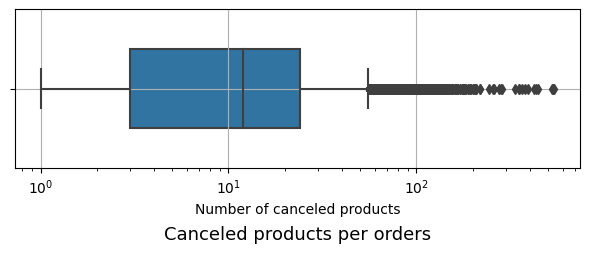

In [12]:
fig = plt.figure(figsize=(6,3))

fig = sns.boxplot(data=nb_products_per_basket, x='Number of products', \
    orient='h', width=0.5)
#plt.axvline(x=boundaries['upper_bound'], color='r')
fig.set_title('Canceled products per orders', y=-0.5, fontsize=13)
fig.set_xlabel('Number of canceled products')
fig.set_xscale('log')
plt.tight_layout()
fig.grid();

> In case of simple return calculation, there were 22190 events recorded which is 5.5 % out of all purchases 401604. In average a canceled order contains $18 \pm 23$ of goods.

In [13]:
# select unique 
data_deduplicated.loc[:,'QuantityCanceled'] = get_quantity_canceled(data_deduplicated)

C:\Users\Lena\AppData\Local\Temp\ipykernel_30512\1857087929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_deduplicated.loc[:,'QuantityCanceled'] = get_quantity_canceled(data_deduplicated)


In [14]:
data_deduplicated['QuantityCanceled'].isna().value_counts()

False    398920
True       2684
Name: QuantityCanceled, dtype: int64

In [15]:
# delete orders without a counterparty
data_cleaned = data_deduplicated.dropna(axis=0)
# delete orders with a negative quantity
negative_qty = data_cleaned[data_cleaned['Quantity']<0]
print('Items with negative quantity: {}'.format(negative_qty.shape[0]))


data_cleaned = data_cleaned[data_cleaned['Quantity']>=0]
data_cleaned.shape

Items with negative quantity: 6188


(392732, 9)

### special transactions

In [16]:
special_transactions = data_cleaned[data_cleaned['StockCode'].str.contains(r"^[a-zA-Z]+", regex=True)]['StockCode'].apply(lambda x: x.lower())

print('Unique codes: {}'.format(list(special_transactions.unique())))

Unique codes: ['post', 'c2', 'm', 'bank charges', 'pads', 'dot']


[These codes](https://www.kaggle.com/code/fabiendaniel/customer-segmentation/notebook) indicates following statuses: 
|code| status |
|:-- | :-- |
| POST| POSTAGE  |
| C2  | shipment costs |
| M   | Manual   |
| BANK CHARGES|Bank Charges   |
| PADS | PADS TO MATCH ALL CUSHIONS |   
| DOT  | DOTCOM POSTAGE |
| D    | Discount       | 

Though these codes hinders understanding of real purchasing power of clients and, therefore, these entries should be dropped.

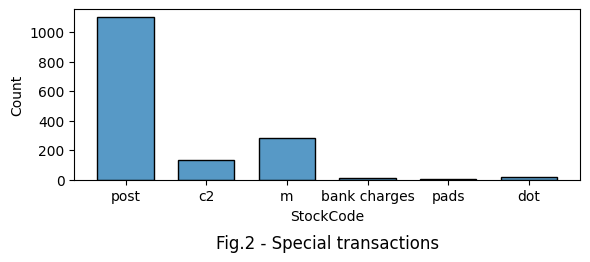

In [17]:
plot_counter = 2
plt.figure(figsize=(6,3))
fig=sns.histplot(special_transactions, shrink=0.7)
#fig.set_xscale('log')
#fig.set_xlabel('Value, sterling')
fig.set_title(f'Fig.{plot_counter} - Special transactions', y=-0.45)
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))
#data_cleaned.drop(['TotalPrice'], axis=0, inplace=True)

In [18]:
data_cleaned = data_cleaned.drop(special_transactions.index, axis=0)
data_cleaned.shape

(391183, 9)

### out-of-unit-price transactions

In [19]:
priceless = data_cleaned[data_cleaned['UnitPrice']<=0]
display(priceless)
data_cleaned.drop(priceless.index, axis=0, inplace=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany,0.0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0.0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911.0,EIRE,0.0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
454464,575579,22089,PAPER BUNTING VINTAGE PAISLEY,24,11/10/2011 11:49,0.0,13081.0,United Kingdom,0.0
479079,577129,22464,HANGING METAL HEART LANTERN,4,11/17/2011 19:52,0.0,15602.0,United Kingdom,0.0
480649,577314,23407,SET OF 2 TRAYS HOME SWEET HOME,2,11/18/2011 13:23,0.0,12444.0,Norway,0.0
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,0.0


### transaction value

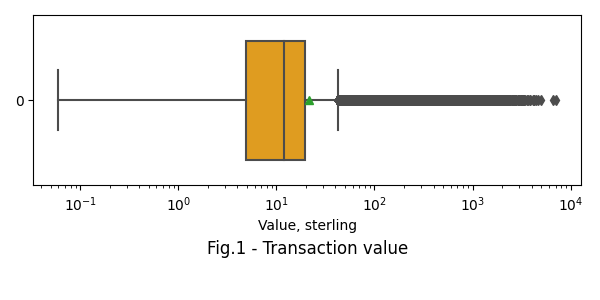

In [33]:
data_cleaned['TotalPrice'] = data_cleaned['UnitPrice'] * (data_cleaned['Quantity'] - data_cleaned['QuantityCanceled'])

positive_value = data_cleaned[data_cleaned['TotalPrice']>0]

plot_counter = 1
plt.figure(figsize=(6,3))
fig=sns.boxplot(positive_value['TotalPrice'], orient='h', width=0.7, color='orange',showmeans=True)
fig.set_xscale('log')
fig.set_xlabel('Value, sterling')
fig.set_title(f'Fig.{plot_counter} - Transaction value', y=-0.45)
plt.tight_layout();
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))
#data_cleaned.drop(['TotalPrice'], axis=0, inplace=True)

### InvoiceDate

In [54]:
positive_value['InvoiceDate'] 

0             2010-12-01 08:26:00
1             2010-12-01 08:26:00
2             2010-12-01 08:26:00
3             2010-12-01 08:26:00
                      ...        
541906        2011-12-09 12:50:00
541907        2011-12-09 12:50:00
541908        2011-12-09 12:50:00
InvoiceDate                   NaT
Name: InvoiceDate, Length: 389189, dtype: datetime64[ns]

In [53]:
positive_value.loc['InvoiceDate'] = pd.to_datetime(positive_value['InvoiceDate'], errors='coerce', dayfirst=True)


C:\Users\Lena\AppData\Local\Temp\ipykernel_30512\612412978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_value.loc['InvoiceDate'] = pd.to_datetime(positive_value['InvoiceDate'], errors='coerce', dayfirst=True)


# 2. Feature analysis

In [3]:
# Save results
#positive_value.to_csv(path_data + 'preprocessed_webshop_data.zip')

data = pd.read_csv(path_data + 'preprocessed_webshop_data.zip', index_col=0)
data['CustomerID'] = data['CustomerID'].astype(int)
data.tail(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
541907,581587.0,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680,France,0.0,16.60
541908,581587.0,22138,BAKING SET 9 PIECE RETROSPOT,3.0,2011-12-09 12:50:00,4.95,12680,France,0.0,14.85


### 2.1 Where do the most profitable customers live ?

In [5]:
temp = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).nlargest(3) 
temp.loc['Other countries'] =  data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)[3:].sum()
temp

Country
United Kingdom     6831156.00
Netherlands         283443.54
EIRE                249016.62
Other countries     937784.09
Name: TotalPrice, dtype: float64

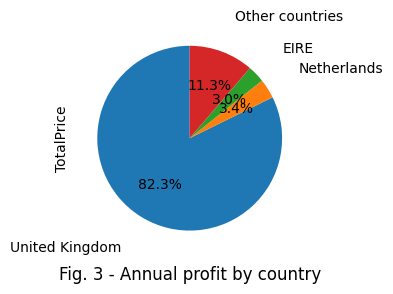

In [17]:
plot_counter = 3
fig = plt.figure(figsize=(6, 3)) 
temp.plot(kind='pie', autopct=lambda v: f'{v:.1f}%', labeldistance = 1.4, startangle=90)

plt.title(f'Fig. {plot_counter} - Annual profit by country', fontsize=12, y=-0.15);
#labels = temp.index
#labels = [f'{l}, {s:0.1g}%' for l, s in zip(labels, temp.values)]
#plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels);

#ax2.set_title('b) exited cliens n=2037', loc='center', y=-0.1);
#fig.legend(loc='upper right', title='Active client status')

In [6]:
plot_counter = 3
fig = px.pie(data_frame=temp, values=temp.values, names=temp.index, height=400,
    width=500) 
fig.update_traces(textposition='outside', 
                  textinfo='percent+label', #+value
                  marker=dict(line=dict(color='#FFFFFF', width=2)),
                  textfont_size=12) 

 

fig.update_layout(
    title=dict(
        text=f'Fig.{plot_counter} - Integral value by country',
        x=.5, y=0.05, xanchor='center'),
        font_size=14,
        #legend = dict(font = dict(size = 13, color = "black"))
)

fig.show()

fig.write_image(path_figures + f'fig_{plot_counter}.png')

### 2.2 Does country revenue have seasonality ?


#### by month

In [58]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
541904,581587.0,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,2011-12-09 12:50:00,0.85,12680.0,France,0.0,10.20
541905,581587.0,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680.0,France,0.0,12.60
541906,581587.0,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60
541907,581587.0,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60
541908,581587.0,22138,BAKING SET 9 PIECE RETROSPOT,3.0,2011-12-09 12:50:00,4.95,12680.0,France,0.0,14.85


In [4]:
# extract month feature from the 'InvoiceDate'
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['date'] = data['InvoiceDate'].dt.date
data['month'] = pd.to_datetime(data['InvoiceDate']).dt.month.astype('category')
data['weekday'] = pd.to_datetime(data['InvoiceDate']).dt.weekday.map({0:'Mon',1:'Tue',2:'Wed', 3:'Thu',4:'Fri', 5:'Sat',6:'Sun'})

In [213]:
temp = data[data['month']==1].groupby(by='Country', as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False)
temp

,Country,TotalPrice
19,United Kingdom,335473.62
12,Netherlands,26596.16
4,EIRE,19135.49
6,France,15995.47
...,...,...
2,Channel Islands,645.08
13,Poland,607.32
3,Cyprus,547.50
9,Iceland,475.39


In [291]:
profitable_countries = set()

for i in range(1,12):
    temp = list(data[data['month']==i].groupby(by='Country')['TotalPrice'].sum().nlargest(2).index)
    for i in temp:
        profitable_countries.add(i)

profitable_countries = [*profitable_countries]
profitable_countries

['Germany', 'United Kingdom', 'Netherlands', 'France', 'EIRE']

In [292]:
temp = data[data['Country'].isin(profitable_countries)].pivot_table(
    values='TotalPrice', 
    index='Country', 
    columns='month', 
    aggfunc='sum').reset_index().fillna(0)#.sort_values(by=1.0, ascending=False).head()
temp 

month,Country,1,2,3,4,5,6,7,8,9,10,11,12
0,EIRE,19135.49,9952.67,17842.18,7270.50,15711.85,19410.99,40372.98,14734.55,40014.24,22465.60,27442.26,14663.31
1,France,15995.47,7655.46,13647.70,3824.31,16124.33,14441.13,9106.64,12574.51,21871.99,23721.43,28071.25,15032.84
2,Germany,14827.33,8710.60,12706.03,10946.19,23387.66,11928.37,14540.79,17575.62,16504.02,27624.59,23731.14,20058.74
3,Netherlands,26596.16,22797.11,22206.49,2886.56,28942.88,26738.09,11.02,40025.41,26832.26,40378.65,25546.41,20482.50
4,United Kingdom,335473.62,350367.73,455916.10,401372.43,534330.47,475260.61,476010.34,485126.55,786464.37,793137.15,948891.01,788805.62


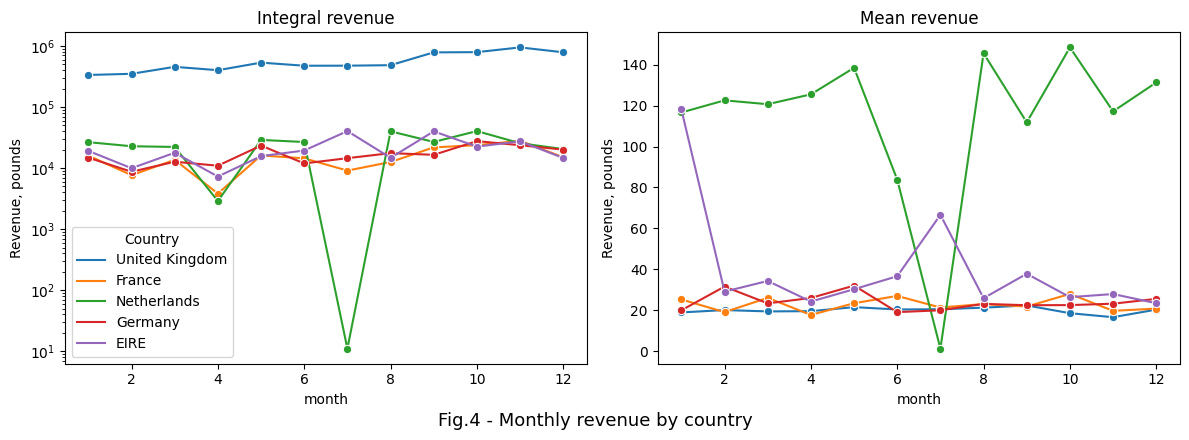

In [293]:
temp = data[data['Country'].isin(profitable_countries)]

plot_counter = 4
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(
    data = temp, x='month', y='TotalPrice',  errorbar=None,  estimator='sum',  
    ax=ax[0],  hue='Country', marker='o') #markers=['o','+','x','s','p']
sns.lineplot(
    data = temp, x='month', y='TotalPrice',  errorbar=None,  
    estimator='mean', ax=ax[1],  hue='Country', marker='o')
 
ax[0].set_yscale('log')
ax[0].set_title('Integral revenue')
ax[0].set_ylabel('Revenue, pounds')
ax[1].set_ylabel('Revenue, pounds')
ax[1].set_title('Mean revenue')
plt.suptitle(f'Fig.{plot_counter} - Monthly revenue by country', y=0.05, size=13)
ax[1].get_legend().remove()
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

#### seasonality by weekday and hour

In [5]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'date', 'month', 'weekday'],
      dtype='object')

In [457]:
# get hour and date
data['UK_time'] = data['InvoiceDate'].dt.hour #.dt.tz_localize(tz='UTC')

temp = data.groupby(by='weekday', as_index=False)['TotalPrice'].sum()
temp 

,weekday,TotalPrice
0,Fri,1233089.20
1,Mon,1305554.61
2,Sun,768416.35
3,Thu,1901080.87
4,Tue,1555832.02
5,Wed,1537427.20


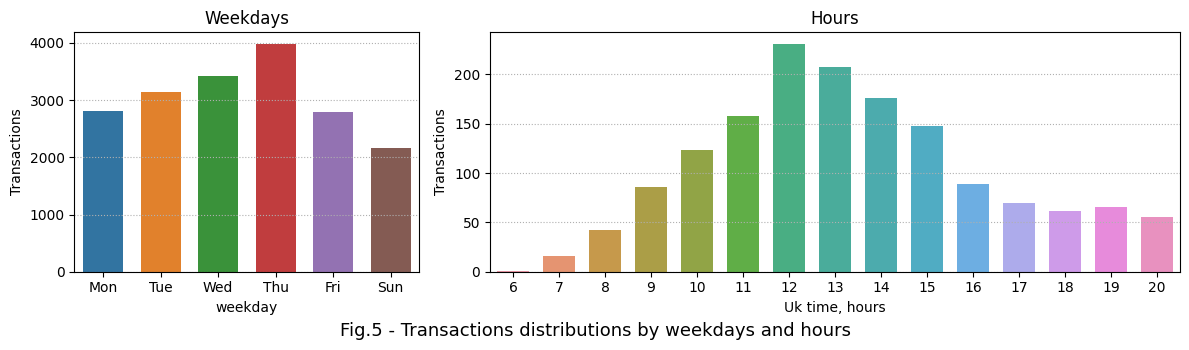

In [305]:
plot_counter = 5
 
temp = data.groupby(by='weekday', as_index=False)['InvoiceNo'].nunique()
temp1 = data.groupby(['date','UK_time'], as_index=False)['InvoiceNo'].count()

temp2 = temp1.groupby(['UK_time'], as_index=False)['InvoiceNo'].mean()

fig, ax = plt.subplots(1,2, figsize=(12,4), width_ratios=[1, 2])
sns.barplot(data=temp, x='weekday', y='InvoiceNo', ax=ax[0],
            order=['Mon', 'Tue', 'Wed', 'Thu','Fri', 'Sun'], width=0.7)
ax[0].set_ylabel('Transactions')
ax[0].set_title('Weekdays')
ax[0].yaxis.grid(linestyle=':')

sns.barplot(data=temp2, x='UK_time', y='InvoiceNo', ax=ax[1], width=0.7)
ax[1].set_ylabel('Transactions')
ax[1].set_xlabel('Uk time, hours')
ax[1].set_title('Hours') 
ax[1].yaxis.grid(linestyle=':')

fig.suptitle(f'Fig.{plot_counter} - Transactions distributions by weekdays and hours', y=0.05, size=13)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

# 3. Segmentation



## 3.1 RFM (Recency, Frequency, Monetary) analysis

In [212]:
#data['recency'] = data['InvoiceDate'].apply(lambda x: (t_0 - x).days)#pd.to_datetime('2011-12-10')

# add 1 day to the maximal date
t_0 = (data['InvoiceDate'].max() + pd.DateOffset(days=1))#).date() 
data['Recency'] = (t_0 - data['InvoiceDate']).dt.days

# how recently did a customer purchase within the designated period (year)
recency = data.groupby(['CustomerID'])['Recency'].min()
recency.head()

CustomerID
12347      2
12348     75
12349     19
12350    310
12352     36
Name: Recency, dtype: int64

In [7]:
# How often do customers purchases?
frequency = data.groupby(['CustomerID'])['InvoiceNo'].nunique().rename('Frequency', inplace=True)
frequency.head()

CustomerID
12347    7
12348    4
12349    1
12350    1
12352    6
Name: Frequency, dtype: int64

In [8]:
# How much do customers spend
value = data.groupby(['CustomerID'])['TotalPrice'].sum().rename('Monetary value', inplace=True)
value.head()

CustomerID
12347    4310.00
12348    1437.24
12349    1457.55
12350     294.40
12352    1265.41
Name: Monetary value, dtype: float64

In [9]:
RFM = pd.merge(recency, frequency, left_index=True, right_index=True)
RFM = pd.merge(RFM, value, left_index=True, right_index=True)
#RFM.rename(columns={'value':'monetary_value'}, inplace=True)
RFM.head()

,Recency,Frequency,Monetary value
CustomerID,,,
12347,2,7,4310.00
12348,75,4,1437.24
12349,19,1,1457.55
12350,310,1,294.40
12352,36,6,1265.41


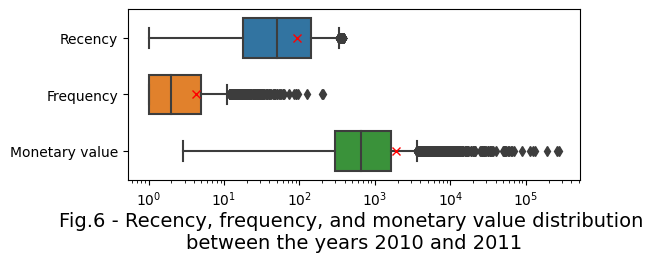

In [484]:
plot_counter = 6
plt.figure(figsize=(6,3))
fig = sns.boxplot(
    RFM, orient='h', width=0.7, showmeans=True,
    meanprops={"marker":"x","markerfacecolor":"red", "markeredgecolor":"red"}
)
fig.set_xscale('log')

fig.set_title(f'Fig.{plot_counter} - Recency, frequency, and monetary value distribution \nbetween the years 2010 and 2011', y=-0.45, size=14)
#ax.set_xlabel('Amount')
plt.tight_layout();

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

Features in the RFM table contains multiple outliers which should be removed.

In [10]:
# ceiling for outliers
for i in ['Frequency', 'Monetary value']:
    RFM[i] = RFM[i].apply(lambda x: RFM[i].quantile(0.95) if x > RFM[i].quantile(0.95) else x)
    
# RFM['Frequency'] = RFM['Frequency'].apply(lambda x: RFM['Frequency'].quantile(0.95) if x > RFM['Frequency'].quantile(0.95))
# RFM['Monetary value'] = RFM['Monetary value'].apply(lambda x: RFM['Monetary value'].quantile(0.95) if x > RFM['Monetary value'].quantile(0.95))

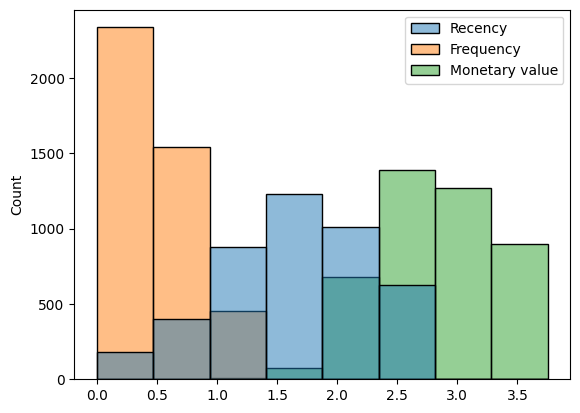

In [556]:
sns.histplot(np.log10(RFM), bins=8); #[['Monetary value', 'Recency', 'Frequency']]

In [540]:
plot_counter = 6

#RFM['Monetary value'] = np.log10(RFM['Monetary value'])

fig = px.box(data_frame=RFM.rename(columns=
    {'Recency':'Recency, days', 
     'Frequency':'Frequency, times per year', 
     'Monetary value':'Monetary value, strelings'
    }), orientation='h')
 
fig.update_layout(
    title=dict(
        text=f'Fig.{plot_counter} - Customer value analysis between the years 2010 and 2011', 
        x=.5, y=0.01, xanchor='center'),
    xaxis_type='log',
    xaxis_title_text = 'Value',
    yaxis_title_text = 'Variables',
    boxmode = "overlay",
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=70),
)

fig.update_traces(boxmean=True)
fig.show()
#fig.write_image(os.path.join(path_figures, f'fig_{plot_counter}.png'))

## 3.2 Clustering

In [164]:
col_names = list(RFM.columns)
scaler = StandardScaler() # MinMaxScaler() #
RFM_scaled = RFM.copy()

RFM_scaled[col_names] = scaler.fit_transform(RFM.values)
RFM_scaled.head()

,Recency,Frequency,Monetary value
CustomerID,,,
12347,-0.906289,1.025297,2.062081
12348,-0.177701,0.126206,0.115419
12349,-0.736618,-0.772885,0.129182
12350,2.167752,-0.772885,-0.659001
12352,-0.566947,0.725600,-0.001018


In [19]:
fig = px.scatter_3d(
    data_frame=RFM_scaled.reset_index(),
    x='Recency',
    y='Frequency',
    z='Monetary value', 
    width=700,
    height=700   
)
 
fig.show()

In [175]:
pipeline = Pipeline([
    ('scaler',  StandardScaler()),  # MinMaxScaler()
    ('pca', PCA(n_components=2, random_state=random_state))
])

# extracting 2 principal components
scaled_pc = pipeline.fit_transform(RFM) 
#scaled_pc[:2]
scaled_pc = pd.DataFrame(scaled_pc, columns=['component_1','component_2'])
scaled_pc.head(2)
#print('Number of components: {}'.format(scaled_pc.shape[1]))

,component_1,component_2
0,2.349376,0.233543
1,0.232879,-0.081207


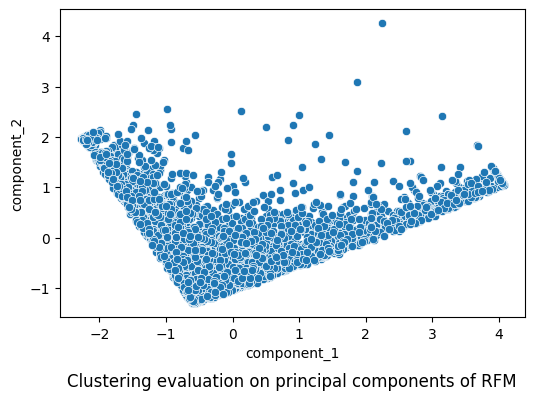

In [29]:
plt.figure(figsize=(6,4))
sns.scatterplot(scaled_pc, x='component_1', y='component_2'); 
plt.title('Clustering evaluation on principal components of RFM', y=-0.25);

### optimal number of clusters

In [166]:
# estimation of the optimal number of clusters by metrics
silhouette_df = get_clustering_metrics(data=scaled_pc, ranges=(3,11))

silhouette_df.head()

,silhouette,cluster,inertia,db_score
0,0.547633,3,2750.463573,0.598506
1,0.523072,4,1729.360031,0.617579
2,0.484856,5,1325.599865,0.660390
3,0.469542,6,1008.268939,0.676966
4,0.439461,7,862.205669,0.737474


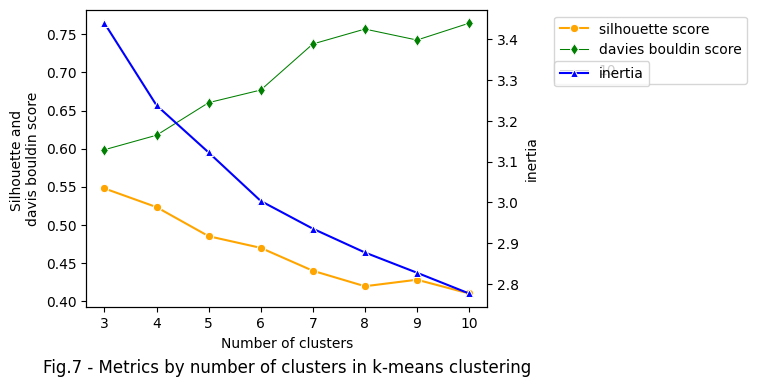

In [167]:
plot_counter = 7

fig, ax = plt.subplots(figsize = (8, 4))
fig = sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o",ax=ax, c='orange', label='silhouette score')
fig = sns.lineplot(data=silhouette_df, x="cluster", y="db_score", marker= "d", size=10, ax=ax, c='green', label='davies bouldin score')

# highlight the optimum value
xx,yy =  np.argmax(silhouette_df['silhouette'].values), np.max(silhouette_df['silhouette'].values)
#plt.scatter(x=xx+3, y=yy, marker= "o", c='r',s=80)
#plt.annotate(f'optimal num_clusters = {xx+2}', xy=(xx+2+0.5, yy))
minor_ticks = np.arange(1, 10, 0.5)
major_ticks = np.arange(2, 11, 1)
ax.set_xticks(major_ticks, minor=True)
fig.set_xlabel('Number of clusters')
fig.set_ylabel('Silhouette and \ndavis bouldin score')
ax.set_title(f'Fig.{plot_counter} - Metrics by number of clusters in k-means clustering', y=-0.25)
ax.legend(bbox_to_anchor=(1.15, 1))

ax2 = ax.twinx() 
fig = sns.lineplot(data=silhouette_df, x="cluster", y=np.log10(silhouette_df["inertia"]), marker= "^",ax=ax2, c='b', label='inertia')
#ax2.set_yscale('log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1.15, 0.85))
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

<Axes: xlabel='Recency', ylabel='Count'>

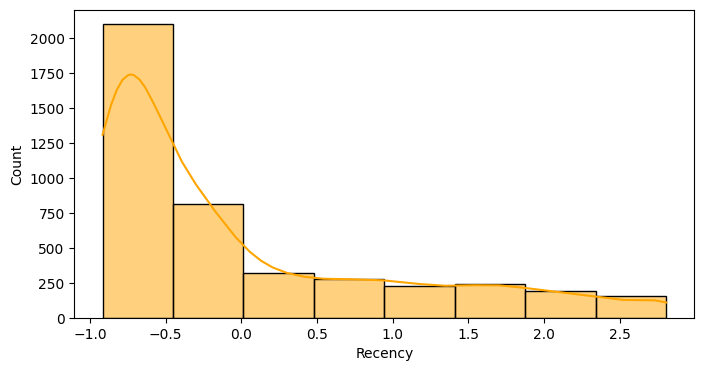

In [121]:
fig, ax = plt.subplots(figsize = (8, 4))
#sns.kdeplot(data=RFM['Recency'])
# ax2 = ax.twinx()
sns.histplot(RFM_scaled['Recency'], color='orange', kde=True,bins=8)#,ax=ax2
#plt.yscale('log')

In [122]:
RFM_scaled['cluster'].value_counts()

0    2572
2    1056
1     701
Name: cluster, dtype: int64

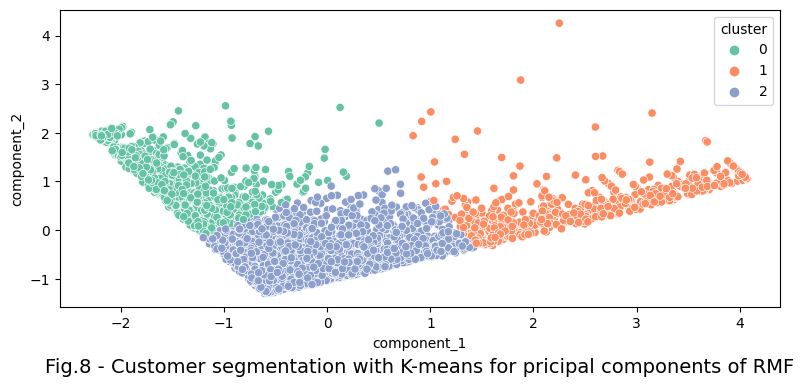

In [195]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=random_state)
kmeans.fit(scaled_pc)
RFM_scaled['cluster'] = kmeans.labels_
scaled_pc['cluster'] = kmeans.labels_
RFM['cluster'] = kmeans.labels_

plot_counter = 8
plt.figure(figsize=(8,4))
fig = sns.scatterplot(data=scaled_pc, x='component_1', y='component_2', hue='cluster', palette="Set2")#;size=RFM["Monetary value"],sizes=(20, 200)

#fig.set_yscale('log')
fig.set_title(f'Fig.{plot_counter} - Customer segmentation with K-means for pricipal components of RMF', y=-0.25, size=14);
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

In [197]:
RFM_scaled['cluster'].value_counts()

2    2572
0    1056
1     701
Name: cluster, dtype: int64

In [225]:
RFM[RFM['cluster']==2].describe()

,Recency,Frequency,Monetary value,cluster
count,2572.000000,2572.000000,2572.000000,2572.0
mean,47.543935,2.753499,854.256878,2.0
std,37.076089,1.714981,685.295769,0.0
min,1.000000,1.000000,5.900000,2.0
25%,18.000000,1.000000,329.790000,2.0
50%,38.000000,2.000000,656.925000,2.0
75%,71.000000,4.000000,1204.015000,2.0
max,180.000000,10.000000,4366.780000,2.0


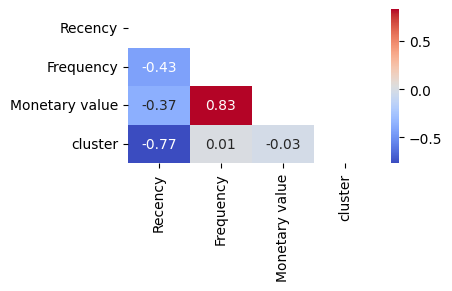

In [184]:
fig = plt.figure(figsize=(4, 2))
 
matrix = np.triu(RFM_scaled.corr())  
fig = sns.heatmap(RFM_scaled.corr(), annot=True, fmt='.02f', cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0
ax.set_title('Fig. - Correlation heatmap', y=-0.15, fontsize=16);

In [228]:
plot_counter = 8

fig = px.scatter_3d(
    data_frame=RFM,
    x='Recency',
    y='Frequency',
    z='Monetary value', 
    color='cluster',
    #color_discrete_sequence=["red", "green","blue"]
    #color_discrete_map={0:"red", 1:"green",2:"blue"}
)

fig.update_layout(
    title=dict(
        text=f'Fig.{plot_counter} - Customer segmentation with K-means for pricipal components of RMF',
        x=.5, y=0.05, xanchor='center'),
    font_size=14,
    width=800, height=700,
    margin=dict(l=100, r=60, t=80, b=70),
)
fig.show()

fig.write_image(path_figures + f'fig_{plot_counter}.png')

### cluster profiles

## Payments forecasting

### Cluster 0

In [58]:
temp = X_scaled[X_scaled['cluster']==0]
X, Y = temp.drop(['PAYMENTS'], axis=1), temp['PAYMENTS']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=random_state)

#### linear regression

In [59]:
# Creation an instance
lr = LinearRegression()

# Training the model
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f'R2 score: { round(r2_score(y_test, y_pred),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred),3)}')

R2 score: 0.476
RMSE score: 0.273
MAPE score: 1.433


In [60]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'R2 score: { round(r2_score(y_test, y_pred),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred),3)}')

R2 score: 0.615
RMSE score: 0.234
MAPE score: 0.972


#### Gradient boosting

In [61]:
def optuna_gbr(trial):
    """
    Hyperparameters optimization for gradient boosting regressor model

    Args:
        trial (_type_): iteration

    Returns:
        (float) r2_score, rmse_score
    """    
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 40, 300, 1)
    max_depth = trial.suggest_int('max_depth', 3, 7, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    min_samples_leaf = trial.suggest_int('max_depth', 2, 15, 1)
   
    # model creation 
    model = GradientBoostingRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=1,
        min_samples_leaf = min_samples_leaf,
        learning_rate=learning_rate,
        random_state=random_state
    )
    
    # training
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r_score = r2_score(y_test, y_pred)
    #rmse_score = mean_squared_error(y_test, y_pred, squared = False)
 
    return r_score #, rmse_score

In [62]:
%%time
# create study set
study = optuna.create_study(study_name="gbr", direction="maximize", sampler=sampler)
# try multiple times
study.optimize(optuna_gbr, n_trials=100)

clear_output(wait=False)

best_hyperparameters = study.best_params
print(f"\tparams: {best_hyperparameters}")

display(optuna.visualization.plot_optimization_history(study, target_name="r_score"))

	params: {'n_estimators': 241, 'max_depth': 5, 'learning_rate': 0.0876020108774834}


CPU times: total: 42.8 s
Wall time: 43 s


In [63]:
# Create the model
gbr = GradientBoostingRegressor(**best_hyperparameters,random_state=random_state, verbose=0)

# Training the model
gbr.fit(X_train, y_train)

# предсказание
y_pred_train, y_pred_test =  gbr.predict(X_train), gbr.predict(X_test)


print(f'R2 score: { round(r2_score(y_test, y_pred_test),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred_test, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred_test),3)}')

R2 score: 0.618
RMSE score: 0.233
MAPE score: 0.874


In [64]:
def get_score(label, y, y_hat):
    
    R2_score = r2_score(y, y_hat)
    RMSE_score = mean_squared_error(y, y_hat, squared = False)
    MAPE_score = mean_absolute_percentage_error(y, y_hat)
    print("{}\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(label, R2_score, RMSE_score, MAPE_score))

print(50 * "_")
print("sample\tR2 score\tRMSE score\tMAPE score")
get_score('train', y_train, y_pred_train)
get_score('test', y_test, y_pred_test)
print(50 * "_")

__________________________________________________
sample	R2 score	RMSE score	MAPE score
train	0.913		0.107		0.811
test	0.618		0.233		0.874
__________________________________________________


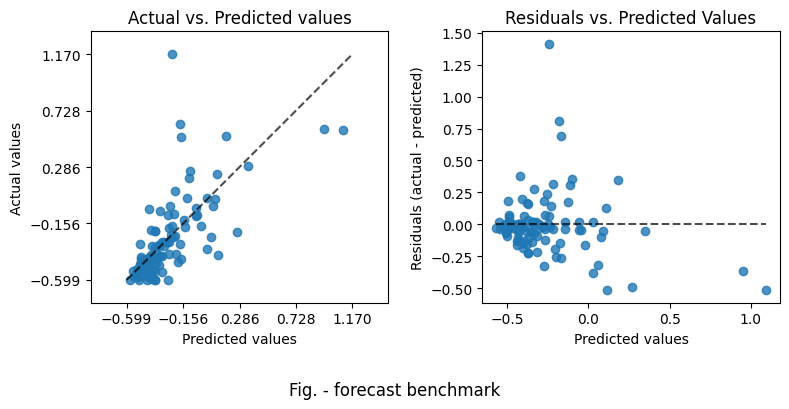

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - forecast benchmark", y=-0.05)
plt.tight_layout()

### Feature analysis

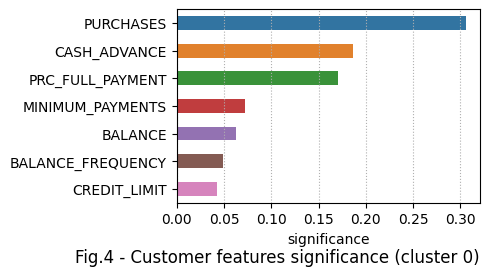

In [66]:
factors = pd.DataFrame({'significance':gbr.feature_importances_}, index=X_train.columns).sort_values(by='significance', ascending=False).iloc[:7]

plot_counter=4

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='significance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Customer features significance (cluster 0)', y=-0.35, loc='right'); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

In [67]:
temp = data[data['cluster']==0][['PRC_FULL_PAYMENT', 'BALANCE_FREQUENCY']]
plt.figure(figsize=(4,2))
sns.boxplot(temp, orient='h', width=0.7)

KeyError: 'cluster'

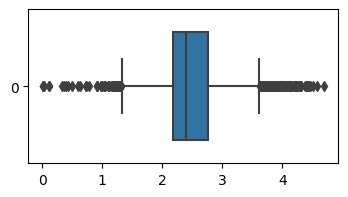

In [ ]:
temp = data[data['cluster']==0]['MINIMUM_PAYMENTS']
plt.figure(figsize=(4,2))
sns.boxplot(np.log10(temp+1), orient='h', width=0.7);

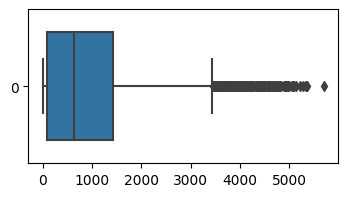

In [ ]:
temp = data[data['cluster']==0]['BALANCE']
plt.figure(figsize=(4,2))
sns.boxplot(temp, orient='h', width=0.7);

In [ ]:
data[data['cluster']==0]['BALANCE'].describe()

count    6209.000000
mean      936.338551
std      1028.333399
min         0.000000
25%        80.513636
50%       635.090434
75%      1420.156349
max      5709.486507
Name: BALANCE, dtype: float64

## Cluster 1

In [ ]:
temp = X_scaled[X_scaled['cluster']==1]
X, Y = temp.drop(['PAYMENTS'], axis=1), temp['PAYMENTS']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=random_state)

In [ ]:
%%time
# create study set
study = optuna.create_study(study_name="gbr", direction="maximize", sampler=sampler)
# try optimization multiple times
study.optimize(optuna_gbr, n_trials=100)

clear_output(wait=False)

best_hyperparameters = study.best_params
print(f"\tparams: {best_hyperparameters}")

optuna.visualization.plot_optimization_history(study, target_name="r_score")

	params: {'n_estimators': 271, 'max_depth': 6, 'learning_rate': 0.04044636521805404}
CPU times: total: 25 s
Wall time: 25 s


In [ ]:
# Create the model
gbr = GradientBoostingRegressor(**best_hyperparameters,random_state=random_state, verbose=0)

# Training the model
gbr.fit(X_train, y_train)

# предсказание
y_pred_train, y_pred_test =  gbr.predict(X_train), gbr.predict(X_test)


print(f'R2 score: { round(r2_score(y_test, y_pred_test),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred_test, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred_test),3)}')

R2 score: 0.571
RMSE score: 0.51
MAPE score: 2.602


In [ ]:
print(50 * "_")
print("sample\tR2 score\tRMSE score\tMAPE score")
get_score('train', y_train, y_pred_train)
get_score('test', y_test, y_pred_test)
print(50 * "_")

__________________________________________________
sample	R2 score	RMSE score	MAPE score
train	0.920		0.208		3.357
test	0.571		0.510		2.602
__________________________________________________


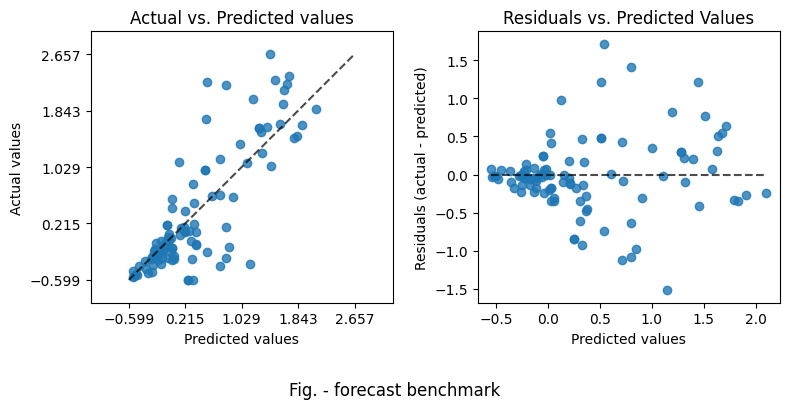

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - forecast benchmark", y=-0.05)
plt.tight_layout()

### Feature analysis

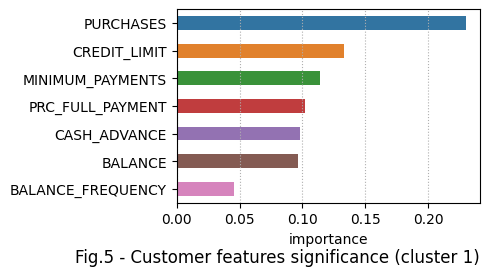

In [ ]:
factors = pd.DataFrame({'importance':gbr.feature_importances_}, index=X_train.columns).sort_values(by='importance', ascending=False).iloc[:7]

plot_counter=5

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='importance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Customer features significance (cluster 1)', y=-0.35, loc='right'); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');
#ax.set_xscale('log')
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))